In [1]:
import sys
sys.path.append("../..")
sys.path.append("../../sac_ae")

In [2]:
import torch
import numpy as np
from IPython import display
from ipywidgets import Output, GridspecLayout
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [3]:
from sac_ae.env import make_envs
from sac_ae.model import make_model
from sac_ae.agent import make_agent
from utils.misc import eval_mode, VideoRecorder
from utils.argument import Arguments

In [94]:
def load_agent_and_args(path, device=torch.device('cpu'), model_name='model/best_model.pt', fix_new_args=False):
    args = Arguments(path + 'args.json')
    if fix_new_args:
        args.cost_samples = 10
        args.cost_allowed_threshold = 0.05
    weights = torch.load(path + model_name, map_location=device)

    if args.agent == 'sac_state':
        agent_obs_shape = weights['actor.encoder.projection.projection.0.weight'].shape[1:]
        args.agent_image_size = agent_obs_shape[0]
    else:
        agent_obs_shape = (3*args.frame_stack, args.agent_image_size, args.agent_image_size)
    action_shape = np.array([4])

    model = make_model(agent_obs_shape, action_shape, args, device)
    agent = make_agent(model, device, action_shape, args)
    agent.load_model_from_dict(weights)
    return agent, args

In [5]:
def one_episode(agent, args, seed, video_name=None, compute_log_std=False):
    if video_name != None:
        video = VideoRecorder('./ensemble_analysis')

    env = make_envs(args, is_eval=True, use_state=True)
    env.seed(seed)
    obs = env.reset()
    
    if video_name != None:
        video.init()
        video.record(env)

    episode_reward, episode_cost = 0, 0
    actions = np.zeros(shape=(env._max_episode_steps, 4))
    
    log_std_list = np.zeros(shape=(env._max_episode_steps, 4))

    for step in range(env._max_episode_steps):
            with eval_mode(agent):
                action = agent.select_action(obs)
                actions[step] = action
                if compute_log_std:
                    obs_torch = torch.FloatTensor(obs).to(device).unsqueeze(0)
                    mu, pi, log_pi, log_std = agent.model.actor(obs_torch, compute_log_pi=True)
                    log_std_list[step] = log_std.detach().cpu().numpy()

            next_obs, reward, done, info = env.step(action)
            if video_name != None:
                video.record(env)
            episode_reward += reward
            if args.cost != 'no_cost':
                episode_cost += info['cost']

            obs = next_obs
    if video_name != None:
        video.save(video_name)
    print(f'Reward: {np.round(episode_reward, decimals=2)}, Cost: {np.round(episode_cost, decimals=2)}')
    if compute_log_std:
        return log_std_list
    return actions

In [6]:
def calc_success_rate(agent, args, seed, num_episodes=100, stochastic=False):
    env = make_envs(args, is_eval=True, use_state=args.agent == 'sac_state')
    env.seed(seed)
    
    num_successes, reward_sum, cost_sum = 0, 0, 0
    
    for i in range(num_episodes): 
        obs = env.reset()

        episode_reward, episode_cost = 0, 0
        done = False

        while not done:
                with eval_mode(agent):
                    if stochastic:
                        action = agent.sample_action(obs)
                    else:
                        action = agent.select_action(obs)

                next_obs, reward, done, info = env.step(action)
                episode_reward += reward
                if args.cost != 'no_cost':
                    episode_cost += info['cost']

                obs = next_obs
        reward_sum += episode_reward
        cost_sum += episode_cost
        success = False
        if info.get('is_success'):
            num_successes += 1
            success = True
    return num_successes / num_episodes, reward_sum / num_episodes, cost_sum / num_episodes

In [8]:
base_path = '../../../output/fetch-push-cost-small-fix-ensemble/SAC_ensemble_'
device = 'cpu'
actions_buffer = []
seed = np.random.randint(10000)
print(seed)

for i in range(3):
    path = base_path + f'{i}/'
    agent, args = load_agent_and_args(path)
    actions = one_episode(agent, args, seed, f'ensemble_{i}.mp4')
    actions_buffer.append(actions)
    #success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 100)
    #print(f'Model: {i}, Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')

5106
Creating window glfw
Reward: -12.01, Cost: 0.02
Creating window glfw
Reward: -20.65, Cost: 0.04
Creating window glfw
Reward: -19.3, Cost: 0


In [10]:
base_path = '../../../output/fetch-push-ae-ensemble/SAC_ensemble_'
seed = np.random.randint(10000)
print(f'Seed: {seed}')

for i in range(4):
    path = base_path + f'{i}/'
    agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='model/1500000.pt')
    success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 500, False)
    print(f'Model: {i}, Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')

Seed: 6007
Model: 0, Success rate: 0.91, Mean reward: -3.57, Mean cost: 0.0
Model: 1, Success rate: 0.73, Mean reward: -6.23, Mean cost: 0.0
Model: 2, Success rate: 0.71, Mean reward: -6.37, Mean cost: 0.0
Model: 3, Success rate: 0.93, Mean reward: -4.34, Mean cost: 0.0


In [9]:
base_path = '../../../output/fetch-push-ae-ensemble/SAC_ensemble_'
seed = np.random.randint(10000)
print(f'Seed: {seed}')

for stochastic in range(2):
    print(f'{"="*20} {"Stochastic" if stochastic else "Deterministic"} {"="*20}')
    for i in range(4):
        path = base_path + f'{i}/'
        agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='best_model.pt')
        success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 500, stochastic)
        print(f'Model: {i}, Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')

Seed: 466
==================== Deterministic ====================
Model: 0, Success rate: 0.94, Mean reward: -3.03, Mean cost: 0.0
Model: 1, Success rate: 0.76, Mean reward: -6.11, Mean cost: 0.0
Model: 2, Success rate: 0.88, Mean reward: -4.65, Mean cost: 0.0
Model: 3, Success rate: 0.82, Mean reward: -5.23, Mean cost: 0.0
==================== Stochastic ====================
Model: 0, Success rate: 0.95, Mean reward: -2.94, Mean cost: 0.0
Model: 1, Success rate: 0.75, Mean reward: -6.02, Mean cost: 0.0
Model: 2, Success rate: 0.89, Mean reward: -4.21, Mean cost: 0.0
Model: 3, Success rate: 0.83, Mean reward: -5.26, Mean cost: 0.0


In [14]:
%%time
base_path = '../../../output/fetch-push-cost-small-ensemble/SAC_ensemble_'
seed = np.random.randint(10000)
print(f'Seed: {seed}')

for stochastic in range(2):
    print(f'{"="*20} {"Stochastic" if stochastic else "Deterministic"} {"="*20}')
    for i in range(3):
        path = base_path + f'{i}/'
        agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='best_model.pt')
        success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 500, stochastic)
        print(f'Model: {i}, Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')


Seed: 1097
==================== Deterministic ====================
Model: 0, Success rate: 0.74, Mean reward: -15.52, Mean cost: 2.31
Model: 1, Success rate: 0.41, Mean reward: -22.0, Mean cost: 1.98
Model: 2, Success rate: 0.68, Mean reward: -17.49, Mean cost: 2.49
==================== Stochastic ====================
Model: 0, Success rate: 0.74, Mean reward: -16.19, Mean cost: 2.49
Model: 1, Success rate: 0.41, Mean reward: -22.79, Mean cost: 2.93
Model: 2, Success rate: 0.64, Mean reward: -17.81, Mean cost: 2.06
CPU times: user 18min 55s, sys: 6.16 s, total: 19min 1s
Wall time: 15min 32s


# After tanh fix

In [12]:
%%time
base_path = '../../../output/fetch-push-cost-small-fix-ensemble/SAC_ensemble_'
seed = np.random.randint(10000)
print(f'Seed: {seed}')

for stochastic in range(2):
    print(f'{"="*20} {"Stochastic" if stochastic else "Deterministic"} {"="*20}')
    for i in range(3):
        path = base_path + f'{i}/'
        agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='model/best_model.pt')
        success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 500, stochastic)
        print(f'Model: {i}, Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')


Seed: 4641
==================== Deterministic ====================
Model: 0, Success rate: 0.81, Mean reward: -12.7, Mean cost: 1.51
Model: 1, Success rate: 0.62, Mean reward: -17.11, Mean cost: 1.77
Model: 2, Success rate: 0.76, Mean reward: -14.94, Mean cost: 2.21
==================== Stochastic ====================
Model: 0, Success rate: 0.79, Mean reward: -12.95, Mean cost: 1.1
Model: 1, Success rate: 0.62, Mean reward: -17.56, Mean cost: 1.91
Model: 2, Success rate: 0.76, Mean reward: -14.42, Mean cost: 1.91
CPU times: user 18min 50s, sys: 6.41 s, total: 18min 56s
Wall time: 15min 27s


In [10]:
grid = GridspecLayout(1, 3)
for i in range(3):
    out = Output()
    with out:
        display.display(display.Video(f'ensemble_analysis/ensemble_{i}.mp4', html_attributes='loop autoplay'))
    grid[0, i] = out
grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

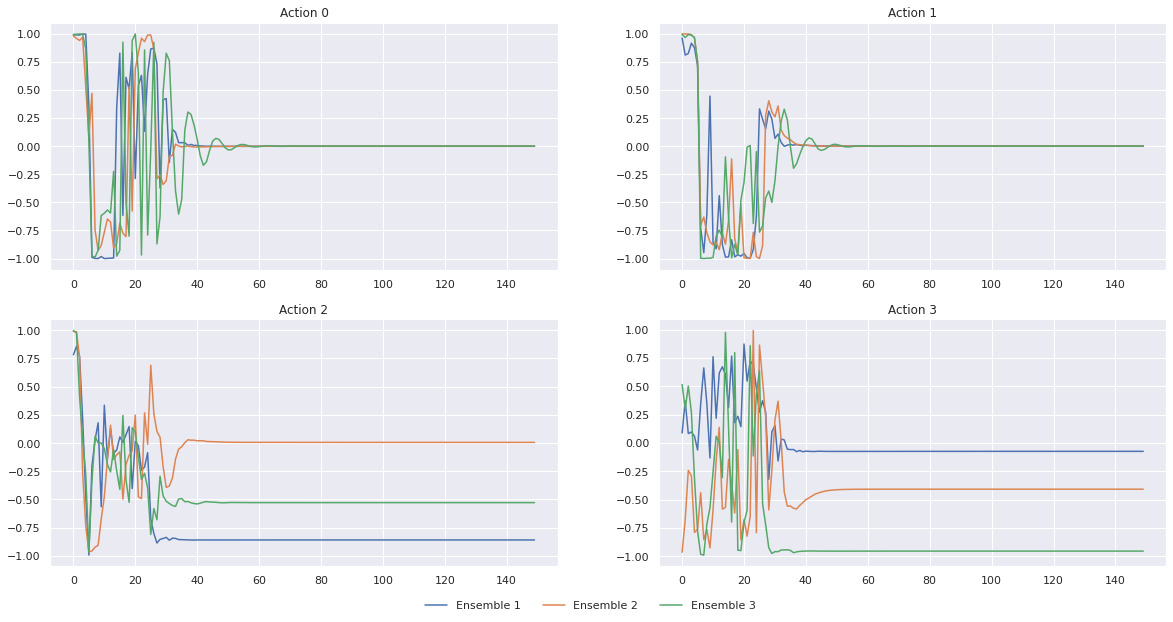

In [11]:
fig = plt.figure(figsize=(20, 10))
for action in range(4):
    ax = fig.add_subplot(2, 2, action+1)
    for i in range(3):
        sns.lineplot(data=actions_buffer[i][:, action], label=f'Ensemble {i}', legend=False)
    ax.set_title(f'Action {action}')
fig.legend(['Ensemble 1', 'Ensemble 2', 'Ensemble 3'])
sns.move_legend(fig, 'lower center', bbox_to_anchor=(.5, 0.05), ncol=3, title=None, frameon=False)
plt.savefig('ensemble_analysis/action_visualization.png', bbox_inches='tight', pad_inches=0)

In [5]:
import pandas as pd

In [18]:
ensemble_results = pd.DataFrame()
seed = np.random.randint(1000000)
seed

582784

In [81]:
reach_results = pd.DataFrame(columns=['environment', 'ensemble_id', 'success_rate', 'mean_reward'])
reach_results['ensemble_id'] = pd.to_numeric(reach_results['ensemble_id'], downcast='integer')
base_path = '../../../output/fetch-reach-ae-ensemble/SAC_ensemble_'
for i in range(3):
    path = base_path + f'{i}/'
    agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='best_model.pt')
    success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 1000, False)
    reach_results.loc[len(reach_results)] = ['FetchReach', i+1, success_rate, mean_reward]

In [53]:
print(reach_results.to_latex(index=False, header=['Environment', 'Id', 'Success Rate', 'Reward']))

\begin{tabular}{lrrr}
\toprule
Environment & Id & Success Rate &    Reward \\
\midrule
 FetchReach &  1 &          1.0 & -0.625487 \\
 FetchReach &  2 &          1.0 & -0.589240 \\
 FetchReach &  3 &          1.0 & -0.498755 \\
\bottomrule
\end{tabular}



In [82]:
push_results = pd.DataFrame(columns=['environment', 'ensemble_id', 'success_rate', 'mean_reward'])
push_results['ensemble_id'] = pd.to_numeric(push_results['ensemble_id'], downcast='integer')
base_path = '../../../output/fetch-push-ae-ensemble/SAC_ensemble_'
model_names = ['best_model.pt', 'best_model.pt', 'model/1500000.pt']
for i, name in enumerate([0,2,3]):
    path = base_path + f'{name}/'
    agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name=model_names[i])
    success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 1000, False)
    push_results.loc[len(push_results)] = ['FetchPush', i+1, success_rate, mean_reward]

In [83]:
barrier_results = pd.DataFrame(columns=['environment', 'ensemble_id', 'success_rate', 'mean_reward', 'mean_cost'])
barrier_results['ensemble_id'] = pd.to_numeric(barrier_results['ensemble_id'], downcast='integer')
base_path = '../../../output/fetch-push-cost-small-'
paths = ['ensemble/SAC_ensemble_0/', 'fix-ensemble/SAC_ensemble_0/', 'fix-ensemble/SAC_ensemble_2/']
for i in range(3):
    path = base_path + paths[i]
    agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='model/best_model.pt')
    success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 1000, False)
    barrier_results.loc[len(barrier_results)] = ['FetchPushBarrier', i+1, success_rate, mean_reward, mean_cost]

In [84]:
results = reach_results.append(push_results, ignore_index=True).append(barrier_results, ignore_index=True)
results

,environment,ensemble_id,success_rate,mean_reward,mean_cost
0,FetchReach,1,1.000,-0.599737,NaN
1,FetchReach,2,1.000,-0.571669,NaN
2,FetchReach,3,1.000,-0.484365,NaN
3,FetchPush,1,0.930,-3.373885,NaN
4,FetchPush,2,0.849,-4.774100,NaN
5,FetchPush,3,0.925,-4.252520,NaN
6,FetchPushBarrier,1,0.726,-14.873336,1.370488
7,FetchPushBarrier,2,0.790,-12.438865,1.074887
8,FetchPushBarrier,3,0.767,-14.937344,2.294314


In [94]:
print(results.round(3).to_latex(index=False, header=['Environment', 'Id', 'Success Rate', 'Reward', 'Cost'], na_rep=''))

\begin{tabular}{lrrrr}
\toprule
     Environment & Id & Success Rate &  Reward &  Cost \\
\midrule
      FetchReach &  1 &        1.000 &  -0.600 &       \\
      FetchReach &  2 &        1.000 &  -0.572 &       \\
      FetchReach &  3 &        1.000 &  -0.484 &       \\
       FetchPush &  1 &        0.930 &  -3.374 &       \\
       FetchPush &  2 &        0.849 &  -4.774 &       \\
       FetchPush &  3 &        0.925 &  -4.253 &       \\
FetchPushBarrier &  1 &        0.726 & -14.873 & 1.370 \\
FetchPushBarrier &  2 &        0.790 & -12.439 & 1.075 \\
FetchPushBarrier &  3 &        0.767 & -14.937 & 2.294 \\
\bottomrule
\end{tabular}



In [12]:
results.to_pickle('results/ensemble_tabe.pkl')

In [6]:
results = pd.read_pickle('results/ensemble_tabe.pkl')

In [97]:
reach_results['mean_reward'].mean().round(3)

-0.552

In [99]:
push_results['mean_reward'].mean().round(3)

-4.134

In [101]:
barrier_results['mean_cost'].mean().round(3)

1.58

In [8]:
grouped = results.groupby(['environment']).mean().reset_index().sort_values(by='success_rate', ascending=False)
grouped

,environment,ensemble_id,success_rate,mean_reward,mean_cost
2,FetchReach,2.0,1.000000,-0.551924,NaN
0,FetchPush,2.0,0.901333,-4.133502,NaN
1,FetchPushBarrier,2.0,0.761000,-14.083182,1.579896


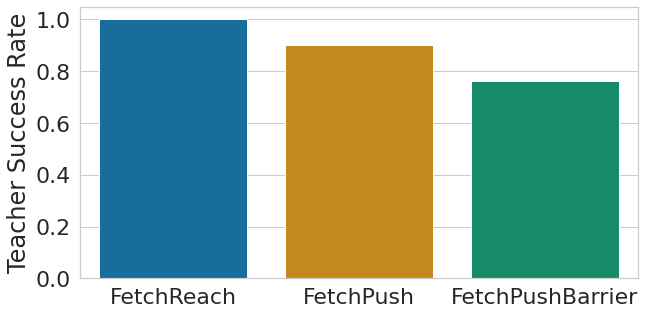

In [40]:
fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
sns.set_context("notebook")
sns.set(style='whitegrid', font_scale=2)

graph = sns.barplot(data=grouped, x='environment', y='success_rate', palette='colorblind')

graph.set(xlabel='', ylabel='Teacher Success Rate')

plt.savefig('results/ensemble_bar.png', bbox_inches='tight')

In [48]:
def calc_avg_confidence(agents, args, seed, num_episodes=100, teacher_index=0):
    env = make_envs(args[0], is_eval=True, use_state=args[0].agent == 'sac_state')
    env.seed(seed)
    
    num_successes, reward_sum, cost_sum, confidence_sum = 0, 0.0, 0.0, 0.0
    
    for i in range(num_episodes): 
        obs = env.reset()

        episode_reward, episode_cost = 0.0, 0.0
        done = False

        while not done:
                with eval_mode(agent):
                    actions = np.asarray(list(map(lambda x: x.select_action(obs), iter(agents))))
                confidence = np.exp(-actions.std(axis=0).mean())
                
                next_obs, reward, done, info = env.step(actions[teacher_index])
                episode_reward += reward
                if args[0].cost != 'no_cost':
                    episode_cost += info['cost']

                obs = next_obs
        reward_sum += episode_reward
        cost_sum += episode_cost
        confidence_sum += confidence
        success = False
        if info.get('is_success'):
            num_successes += 1
            success = True
    return num_successes / num_episodes, reward_sum / num_episodes, cost_sum / num_episodes, confidence_sum / num_episodes

In [23]:
import pandas as pd

In [9]:
seed = np.random.randint(1000000)
seed

266780

In [44]:
teacher_confidence_results = pd.DataFrame(columns=['environment', 'success_rate', 'mean_reward', 'mean_cost', 'mean_confidence'])

In [46]:
base_path = '../../../output/fetch-push-cost-small-'
paths = ['ensemble/SAC_ensemble_0/', 'fix-ensemble/SAC_ensemble_0/', 'fix-ensemble/SAC_ensemble_2/']
agents = []
args_list = []
for i in range(3):
    path = base_path + paths[i]
    agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='model/best_model.pt')
    agents.append(agent)
    args_list.append(args)

In [50]:
success_rate, mean_reward, mean_cost, mean_confidence = calc_avg_confidence(agents, args_list, seed, 1000, 1)
teacher_confidence_results.loc[len(teacher_confidence_results.index)] = ['FetchPushBarrier', success_rate, mean_reward, mean_cost, mean_confidence]

In [51]:
base_path = '../../../output/fetch-push-ae-ensemble/SAC_ensemble_'
model_names = ['best_model.pt', 'best_model.pt', 'model/1500000.pt']
agents = []
args_list = []
for i, name in enumerate([0,2,3]):
    path = base_path + f'{name}/'
    agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name=model_names[i])
    agents.append(agent)
    args_list.append(args)

In [52]:
success_rate, mean_reward, mean_cost, mean_confidence = calc_avg_confidence(agents, args_list, seed, 1000, 0)
teacher_confidence_results.loc[len(teacher_confidence_results.index)] = ['FetchPush', success_rate, mean_reward, mean_cost, mean_confidence]

In [53]:
base_path = '../../../output/fetch-reach-ae-ensemble/SAC_ensemble_'
agents = []
args_list = []
for i in range(3):
    path = base_path + f'{i}/'
    agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='best_model.pt')
    agents.append(agent)
    args_list.append(args)

In [54]:
success_rate, mean_reward, mean_cost, mean_confidence = calc_avg_confidence(agents, args_list, seed, 1000, 0)
teacher_confidence_results.loc[len(teacher_confidence_results.index)] = ['FetchReach', success_rate, mean_reward, mean_cost, mean_confidence]

In [55]:
teacher_confidence_results

,environment,success_rate,mean_reward,mean_cost,mean_confidence
0,FetchPushBarrier,0.795,-12.659242,1.335643,0.724027
1,FetchPush,0.938,-3.245770,0.000000,0.791634
2,FetchReach,1.000,-0.596807,0.000000,0.908277


In [56]:
teacher_confidence_results.to_pickle('results/ensemble_confidence_table.pkl')

In [9]:
teacher_confidence_results = pd.read_pickle('results/ensemble_confidence_table.pkl')
teacher_confidence_results

,environment,success_rate,mean_reward,mean_cost,mean_confidence
0,FetchPushBarrier,0.795,-12.659242,1.335643,0.724027
1,FetchPush,0.938,-3.245770,0.000000,0.791634
2,FetchReach,1.000,-0.596807,0.000000,0.908277


In [10]:
teacher_confidence_results= teacher_confidence_results.sort_values(by='success_rate', ascending=False)

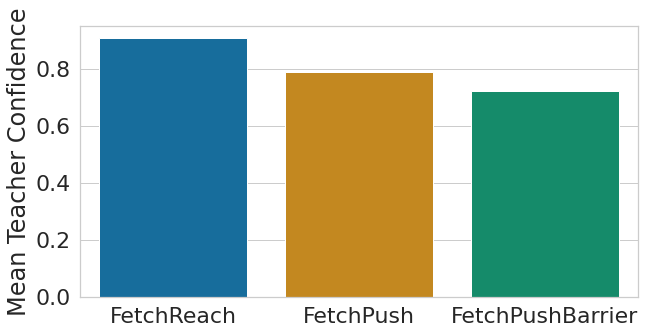

In [60]:
fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
sns.set_context("notebook")
sns.set(style='whitegrid', font_scale=2)

graph = sns.barplot(data=teacher_confidence_results, x='environment', y='mean_confidence', palette='colorblind')

graph.set(xlabel='', ylabel='Mean Teacher Confidence')

plt.savefig('results/ensemble_confidence_bar.png', bbox_inches='tight')

In [63]:
grouped

,environment,ensemble_id,success_rate,mean_reward,mean_cost
2,FetchReach,2.0,1.000000,-0.551924,NaN
0,FetchPush,2.0,0.901333,-4.133502,NaN
1,FetchPushBarrier,2.0,0.761000,-14.083182,1.579896


In [64]:
teacher_confidence_results

,environment,success_rate,mean_reward,mean_cost,mean_confidence
2,FetchReach,1.000,-0.596807,0.000000,0.908277
1,FetchPush,0.938,-3.245770,0.000000,0.791634
0,FetchPushBarrier,0.795,-12.659242,1.335643,0.724027


In [11]:
combined = grouped.merge(teacher_confidence_results[['environment', 'mean_confidence']], on='environment')
combined

,environment,ensemble_id,success_rate,mean_reward,mean_cost,mean_confidence
0,FetchReach,2.0,1.000000,-0.551924,NaN,0.908277
1,FetchPush,2.0,0.901333,-4.133502,NaN,0.791634
2,FetchPushBarrier,2.0,0.761000,-14.083182,1.579896,0.724027


In [12]:
melted = combined.melt(id_vars=['environment'], value_vars=['success_rate', 'mean_confidence'])
melted

,environment,variable,value
0,FetchReach,success_rate,1.000000
1,FetchPush,success_rate,0.901333
2,FetchPushBarrier,success_rate,0.761000
3,FetchReach,mean_confidence,0.908277
4,FetchPush,mean_confidence,0.791634
5,FetchPushBarrier,mean_confidence,0.724027


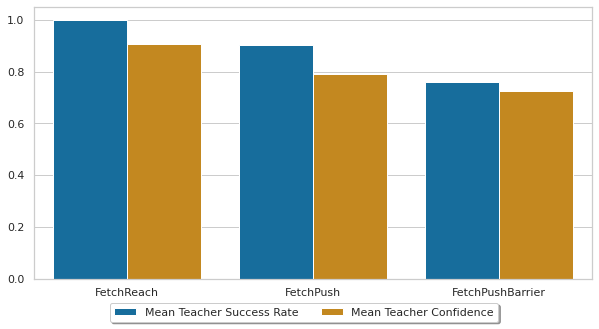

In [18]:
fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
sns.set_context("notebook")
sns.set(style='whitegrid')

graph = sns.barplot(data=melted, x='environment', y='value', hue='variable', palette='colorblind')

h, l = graph.get_legend_handles_labels()
graph.set(xlabel='', ylabel='')
graph.legend([],[], frameon=False)

fig.legend(loc='lower center', 
           bbox_to_anchor=(0.5, -0.01), 
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           #prop={'size': 19},
           labels=['Mean Teacher Success Rate', 'Mean Teacher Confidence'],
           handles=h)
plt.savefig('results/ensemble_combined_bar.png', bbox_inches='tight')